<a href="https://colab.research.google.com/github/doblepensador/Tests/blob/master/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [42]:
from sklearn.datasets import fetch_covtype, fetch_20newsgroups, make_blobs

# Bayes theory 의 Prior는 Guessing 혹은 이미 알고 있다고 생각하고 진행


In [3]:
# 예를 들어, Friend란 단어가 스팸 메일에 들어 있을 확률은 우리가 일정 데이터를 조사해서 얻을 수 있다. 
# 마찬 가지로, 어떤 메일이 왔을 때 그 메일이 스팸일 확률 또한 어느 정도 데이터 조사를 통해 얻을 수 있다. 
# 그렇다면, 어떤 메일이 왔는데 그 메일 안에 Friend란 단어가 들어 있다고 가정해 보자. 이 메일은 스팸일까 친구로부터 온 메일일까? 
# 단순하게 생각해서 당연히 친구한테서 온 편지라고 생각하기 쉬운데, 이는 스팸이 얼마나 광범위하게 퍼져 있는지를 간과한 예측이다. 
# 따라서, 어떤 메일이 Friend라는 단어를 포함하고 있다고 해도, 
# 1) 전체 메일 중에 스팸이 차지하는 비율, 
# 2) Friend라는 단어가 그렇게 강력하게 신뢰할 만한 단어인지
# 고려해야 한다. P(Spam|Friend란 단어가 들어간 메일) * P(Friend란 단어가 들어간 메일) = P(Spam) * P(Friend란 단어가 들어갈 확률|Spam)
# 우리는 일반적으로 a) P(Friend)를 상수 처리할 수 있고, b) P(Spam), P(Friend|Spam)은 데이터 분석을 통해서 비교적 정확하게 예측할 수 있다. 
# 이러한 원리가 클래스 예측 (Spam인지 아닌지 예측) 하는 데 쓰이는 게 Naive Bayes Classification 이다. 

prior = [0.45, 0.3, 0.15, 0.1] #어떤 카테고리(Class)에 들어가는지에 대한 전체적인 확률 (Probability)
likelihood = [[0.3, 0.3, 0.4], 
              [0.7, 0.2, 0.1], 
              [0.15, 0.5, 0.35], 
              [0.6, 0.2, 0.2]] #각각의 카테고리(Class)의 개개의 Feature에 대한 확률(Likelihood)

# Naive Bayes Classification의 기본 동작에 대한 함수                        
idx = 0 
for c, xs in zip(prior, likelihood):
  result = 1.
  
  for x in xs:
    result *= x 
  result *= c
  
  idx += 1 
  # print(f"{idx}번째 클래스의 가능성: {result}")
  print("{}번째 클래스의 가능성: {}".format(idx, result))


1번째 클래스의 가능성: 0.0162
2번째 클래스의 가능성: 0.0042
3번째 클래스의 가능성: 0.0039375
4번째 클래스의 가능성: 0.0024000000000000002


In [4]:
# "Zip 함수" 예시
for pair in zip(prior, likelihood): 
  print(pair)


(0.45, [0.3, 0.3, 0.4])
(0.3, [0.7, 0.2, 0.1])
(0.15, [0.15, 0.5, 0.35])
(0.1, [0.6, 0.2, 0.2])


# 산림토양 데이터

In [ ]:
covtype = fetch_covtype()
print(covtype.DESCR)


In [10]:
covtype_X = covtype.data
covtype_y = covtype.target

In [28]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X,covtype_y, test_size=0.2)

In [25]:
# Feature들이 모두 Numeric(Float)이기 때문에 그냥 Scaling 하면된다. 
scaler = StandardScaler()
covtype_X_train_scaled = scaler.fit_transform(covtype_X_train)
covtype_X_test_scaled = scaler.transform(covtype_X_test)

# 20 Newsgroup 데이터 (TEXT 기반 정보)

In [ ]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)
# Dimensionality가 1인 점을 확인. 텍스트 기반 테이터. 

In [14]:
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

In [15]:
X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

## 텍스트 전처리 (벡터화)

### CountVectorizer : 문서에 나온 단어의 수를 세서 벡터로 생성

In [16]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [ ]:
# Sparsity Matrix : 첫번째 문서[0]의 어떤 단어가 몇번 나왔는지 확인
# Sparse data set with high dimension as it does not have enough data in each column and row. 
# It can be a huge problem when ML is performed because of high demand on the memory. 
for v in X_train_count[0]:
  print(v)

###HashVectorization

In [70]:
# hashing trick to overcome the problems of the sparse matrix (bag-of-words concept).
# Array, Linkedlist, Hashtables
# The first two is highly memory-consuming. 
# the process of hashing trick 
# input - hash function - hash value - divided by the No. of Index and take the remainder of them
# As values, words are saved sequentially as a linked list. 
# Here, each index is considered as each feature. 
# This way, we can reduce the dimension. 

# For it to be applied to Multinomial NB, there must not be negative values for features.
# Therefore, alternate_sign variable should be "False." 

hash_vectorizer = HashingVectorizer(n_features=1000, alternate_sign=False)
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)
 

In [ ]:
print(X_train_hash[0])

###Term-Frequency-Inverse-Document-Frequency (TFIDF) vectorization 

In [22]:
# As the term implies, it takes into account 
# both the frequency of a certain word and how often the word is being used in a broader sense. 
# Simple frequency (TF) x Log(Inverse Document Frequency)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
for v in X_train_tfidf[0]:
  print(v)

# Gaussian Naive Bayes (for 산림토양자료)

---



In [26]:
# Multinomial Naïve Bayes consider a feature vector 
# where a given term represents the number of times it appears or very often i.e. frequency. 
# On the other hand, Bernoulli is a binary algorithm used when the feature is present or not. 
# At last Gaussian is based on continuous distribution.

model = GaussianNB()
model.fit(covtype_X_train_scaled, covtype_y_train) 


GaussianNB()

In [36]:
predict = model.predict(covtype_X_train)
acc = metrics.accuracy_score(covtype_y_train, predict)
f1 = metrics.f1_score(covtype_y_train, predict, average=None)

print("Accuray: {}".format(acc))
print("F1 score: {}".format(f1))

Accuray: 0.48843073176293916
F1 score: [0.         0.65606531 0.         0.         0.         0.
 0.02880212]


In [37]:
predict = model.predict(covtype_X_test_scaled)
acc = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print("Accuray: {}".format(acc))
print("F1 score: {}".format(f1))

Accuray: 0.04586800685008132
F1 score: [0.09643769 0.01067609 0.07078492 0.00674578 0.0319422  0.00919207
 0.06089008]


In [38]:
def make_meshgrid(x, y, h= 0.02):
  x_min, x_max = x.min()-1, x.max()+1
  y_min, y_max = y.min()-1, y.max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  return xx, yy

In [39]:
def plot_contours(clf, xx, yy, **params):
  Z = clf.predict(np.column_stack([xx.ravel(), yy.ravel()]))
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx, yy, Z, **params)
  return out

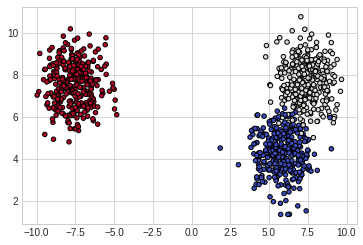

In [50]:
# 토양 데이터에 대해서 시각화는 너무 많은 시간이 걸리고 크래시 될 수도 있음 
# make_blobs로 방법론만 확인. 
X, y = make_blobs(n_samples=1000)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');


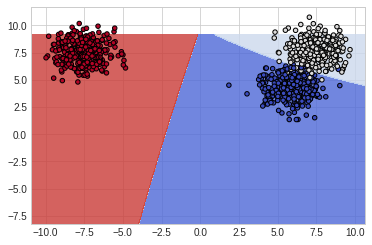

In [51]:
model = GaussianNB()
model.fit(X, y)
xx, yy = make_meshgrid(X[:,0], X[:1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

# Bernoulli Naive Bayes (for 의안에 대한 찬반투표 결과로 의원정당 예측) 

In [ ]:
# 입력된 특성이 이진의 값을 갖는다고 가정한 모델 
# 어떤 단어가 있는지/없는지만 보고 그 빈도수는 보지 않는 모델
# 예를 들어, 어떤 의원이 의회에서 찬성/반대를 투표한 패턴만을 보고, 
# 그 의원이 공화당인지 민주당인지 예측하는 모델이라고 볼 수 있다. 

# Multinomial Naïve Bayes consider a feature vector 
# where a given term represents the number of times it appears or very often i.e. frequency. 
# On the other hand, Bernoulli is a binary algorithm used when the feature is present or not. 
# At last Gaussian is based on continuous distribution.



# Multinomial Naive Bayes (for 20 Newsgroup 데이터)

### Multinomial with Count Vector

In [64]:
model = MultinomialNB()
model.fit(X_train_count, y_train)
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Accuracy: {}".format(acc))
print("F1 score: {}".format(f1))


Accuracy: 0.9245182959165635
F1 score: [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [65]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Accuracy: {}".format(acc))
print("F1 score: {}".format(f1))

Accuracy: 0.7728359001593202
F1 score: [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


### Multinomial with Hash Vector

In [72]:
# For it to be applied to Multinomial NB, there must not be negative values for features.
# Therefore, alternate_sign variable should be "False." 

model = MultinomialNB()
model.fit(X_train_hash, y_train)
predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Accuracy: {}".format(acc))
print("F1 score: {}".format(f1))


Accuracy: 0.7718755524129397
F1 score: [0.72901679 0.70511779 0.77653149 0.73054873 0.78481013 0.80415945
 0.74938373 0.77691108 0.82205514 0.85477178 0.88265306 0.86495443
 0.71615721 0.7972973  0.83121289 0.65154159 0.82019486 0.87878788
 0.6961326  0.27002288]


In [73]:
predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Accuracy: {}".format(acc))
print("F1 score: {}".format(f1))

Accuracy: 0.6143122676579925
F1 score: [0.47265625 0.5548854  0.60550459 0.55921856 0.6113307  0.5900277
 0.73284314 0.64479638 0.74022989 0.7027027  0.8046875  0.72976339
 0.40520984 0.53825137 0.69299363 0.56542056 0.6037296  0.72934473
 0.40669856 0.13235294]


### Multinomial with TF-IDF Vector

In [67]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Accuracy: {}".format(acc))
print("F1 score: {}".format(f1))


Accuracy: 0.9326498143892522
F1 score: [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [68]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Accuracy: {}".format(acc))
print("F1 score: {}".format(f1))

Accuracy: 0.7738980350504514
F1 score: [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]
